In [ ]:
#default_exp crono

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2

In [ ]:
#hide 
import os 
os.chdir('/home/frank/Work/Projecten/DoRe/data/maxrf/crono')

# Gridify by selection

> How to convert wobbly positions into a regular spectral image data cube?  


Now that we have a rough idea about the contents of the different datasets, we are ready to visualize the spectral data. As we shall see there is a problem with the motor positions that we need to resolve. In order to make clear what the issue is, we need to plot the (x,y) motor positions and the selected spectra. Information about the motor positions and selected spectra is stored in datasets **17** and **28**. 

The actual spectral data that we would like to visualize in element maps is stored in a two dimensional table. Note that the table does not contain any information about the pixel position at which each spectrum was measured. 

In [ ]:
#hide 
from cronomaxrf import read_datasets 

crono_filename = '14200215102021-blindTest2AgedDetail.HDF5'   # 50 Mb 
datasets = read_datasets(crono_filename)

for i, d in enumerate(datasets):   
    star = ' '
    if i in [14, 17, 26, 28]: 
        star = '*'
        print(f' {star}[{i}] {d.name}')

 *[14] /XRF/EnergyVector
 *[17] /XRF/MotorsPositions
 *[26] /XRF/Spectra
 *[28] /XRF/SpectraSelectedIndex


In [ ]:
#hide 
spectra = datasets[26][...]
n_spectra, n_channels = spectra.shape
print(f'The spectral data contains {n_spectra} spectra, and each spectrum contains {n_channels} energy channels.')

The spectral data contains 4284 spectra, and each spectrum contains 4096 energy channels.


In [ ]:
#hide 
x, y, z = datasets[17][...].T 
selected_array = datasets[28][...]
selected_array = selected_array[:,:,0] 
selected = selected_array.flatten()

height, width = selected_array.shape[0:2] 
n_sel_spectra = height * width
print(f'The (selected) spectral image cube has a height x width of' + 
      f' {height}x{width} pixels = {n_sel_spectra} spectra.')

The (selected) spectral image cube has a height x width of 85x37 pixels = 3145 spectra.


One would expect to find a rectangular array of sensor positions. Now let's plot the (x, y) positions of all 4284 measured spectra (blue) and see which 3145 positions have been selected (red) by the Crono software. 

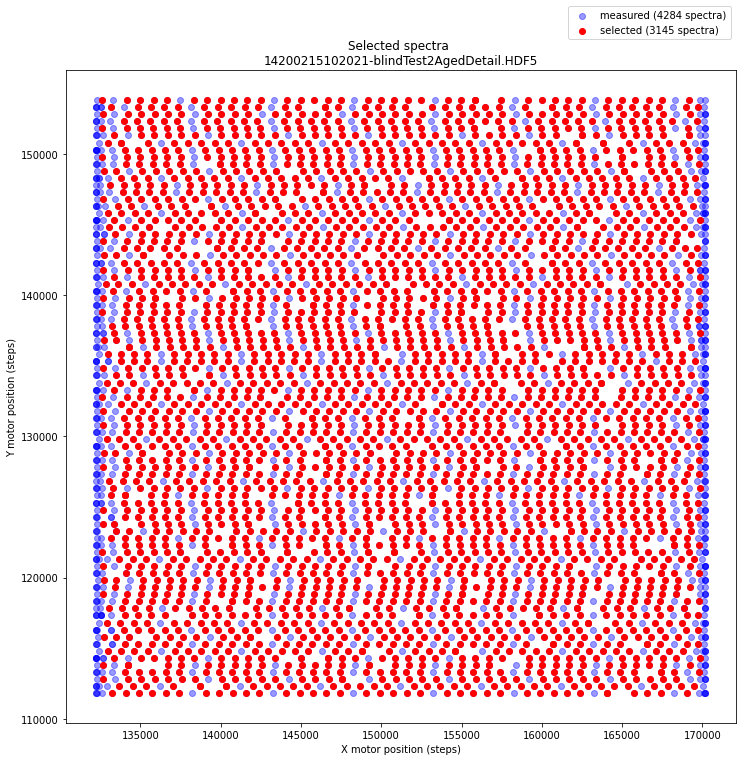

In [ ]:
#hide_input 
import matplotlib.pyplot as plt 
import numpy as np 

fig, ax = plt.subplots(figsize=[12, 12])
ax.scatter(x, y, c='b', alpha=0.4, label=f'measured ({n_spectra} spectra)')
ax.scatter(x[selected], y[selected], color='r', label=f'selected ({len(selected)} spectra)')
ax.set_xlabel('X motor position (steps)')
ax.set_ylabel('Y motor position (steps)')
ax.legend(bbox_to_anchor=(1,1.04), loc="lower right")
ax.set_title(f'Selected spectra \n{crono_filename}');

Mm, the xy positions of the sensor are a bit wobbly. We observe 85 rows of selected (*y*) positions. In each row we count 37 selected spectra (red dots). In order create a regular spectral image cube, the Crono software throws away quite some data (all blue dots). It seems that one could do a better job by interpolating. This is the topic of the next section. 

For now let's follow the crude but effective strategy of the Crono software for exporting to a regular grid (**gridify**) by selecting the red dot spectra and save as regular hdf5 file so that Ana can process the data with her own software. Although our tiny demo data files fit well into memory, typical MA-XRF data files can be rather big. In order to be ready for these big files we make use of excellent python package [dask](https://docs.dask.org/en/stable/) that enables efficient processing of files that do not fit into memory by directly reading and writing to our hard disk.  

For exporting the selected spectra from the crono HDF5 file into a regular spectral image hdf5 file, now simply use the `gridify()` function as shown below.  

In [ ]:
from cronomaxrf import gridify 

gridify('14200215102021-blindTest2AgedDetail.HDF5')


Converting '14200215102021-blindTest2AgedDetail.HDF5':

(1/2) Writing dataset '/maxrf_image' with shape (85, 37, 4096) to hdf5 file...
[########################################] | 100% Completed |  0.2s
(2/2) Writing dataset '/maxrf_energies' with shape (4096,) to hdf5 file...
[########################################] | 100% Completed |  0.1s
File size: 25.0 MB


'14200215102021-blindTest2AgedDetail_GRIDIFIED.HDF5'

The exported (**gridified**) HDF5 file contains the selected spectral data cube that we need for further processing. Typically one now proceeds to obtain element maps. To see how this is done we can compute the iron map from the Fe_Ka band. To easily inspect the contents of our freshly created HDF5 file, use the `read_datasets()` function again. This file only contains two datasets.  

In [ ]:
datasets = read_datasets('14200215102021-blindTest2AgedDetail_GRIDIFIED.HDF5')
for i, d in enumerate(datasets): 
    print(f' {star}[{i}] {d.name} {d.shape} {d.dtype}')

  [0] /maxrf_energies (4096,) float32
  [1] /maxrf_image (85, 37, 4096) uint16


We can make a map for iron by integrating over the 6.1-6.7 keV energy band. 

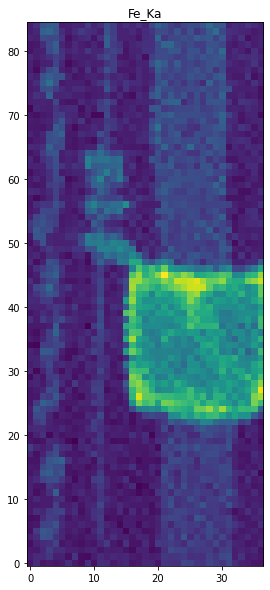

In [ ]:
# Fe_Ka band 
energies = datasets[0][...]
cube = datasets[1][...]
is_iron_Ka_band = (energies > 6.1) * (energies < 6.7) 
n_channels = np.sum(is_iron_Ka_band) # number of channels in the Fe_Ka band 

# integrate FeKa band 
FeKa_slice = cube[:,:,is_iron_Ka_band]
FeKa_map = FeKa_slice.sum(axis=2) / n_channels 

# make plot 
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=[14, 10])
ax.imshow(FeKa_map, origin='lower')
ax.set_title('Fe_Ka map');

**That is it!** We no longer depend on the Crono software for exporting the spectral data in a regular hdf5 file. 

In the next section we will look into improving the export by interpolation... 

## API 

In [ ]:
#export 

# python package for reading hdf5 files 
import h5py 

# python package for processing too-big-for-memory data 
import dask 
import dask.array as da 
#import dask_ndfilters 
from dask.diagnostics import ProgressBar 

# standard imports  
import re 
import os

def gridify(crono_filename): 
    '''Export Crono maxrf file spectral data into regular spectral image hdf5 file. '''
    
    MAXRF_IMAGE = '/maxrf_image'
    MAXRF_ENERGIES = '/maxrf_energies'

    with h5py.File(crono_filename, mode='r') as fh: 

        # read spectra and energies from hdf5 dataset into (lazy) dask arrays  
        spectra = fh['/XRF/Spectra']
        dask_spectra = da.from_array(spectra) 
        energies = fh['/XRF/EnergyVector']
        dask_energies = da.from_array(energies)

        # load selected indices into memory as numpy array 
        selected = fh['/XRF/SpectraSelectedIndex'][:,:,0]  
        dask_gridified = dask_spectra.vindex[selected] # dask (lazy) fancy indexing 

        # create filename for saving to 
        ptrn = '\.[^\.]*$'  
        repl = '_GRIDIFIED.HDF5'
        gridified_filename = re.sub(ptrn, repl, crono_filename)

        # write gridified spectral image to hdf5 file 
        print(f'Converting \'{crono_filename}\':\n')
        
        print(f'(1/2) Writing dataset \'{MAXRF_IMAGE}\' with shape {dask_gridified.shape} to hdf5 file...') 
        with ProgressBar(): 
            dask_gridified.to_hdf5(gridified_filename, MAXRF_IMAGE)

        # also write channel energies to hdf5 file 
        print(f'(2/2) Writing dataset \'{MAXRF_ENERGIES}\' with shape {dask_energies.shape} to hdf5 file...')
        with ProgressBar(): 
            dask_energies.to_hdf5(gridified_filename, MAXRF_ENERGIES)
            
        filesize_MB = os.path.getsize(gridified_filename) // 1e6
        print(f'File size: {filesize_MB} MB')
            
        return gridified_filename
